# Deep Learning for tensiometry of pendant drop

### Import necessary packages and self-defined classes

In [1]:
# pyplot
import matplotlib.pyplot as plt
# pytorch
import torch
import torch.optim as optim
import torch.nn.functional as F  # useful stateless functions
#Test/Train data split
from functools import lru_cache
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import logging
# sklearn
from sklearn import preprocessing
# os
import os
# warnings
import warnings
warnings.filterwarnings('ignore')
# random
import random
# math
import math

# self-defined model
from model_pic import *
from model_cal import *
import pandas as pd

#PictureNet
from PIL import Image
from skimage.io import imread
from sklearn.model_selection import train_test_split

## Dataset loading and preprocessing

In [2]:
class DataSplit:

    def __init__(self, dataset, test_train_split=0.8, val_train_split=0.1, shuffle=False):
        self.dataset = dataset

        dataset_size = len(dataset)
        self.indices = list(range(dataset_size))
        test_split = int(np.floor(test_train_split * dataset_size))

        if shuffle:
            np.random.shuffle(self.indices)

        train_indices, self.test_indices = self.indices[:test_split], self.indices[test_split:]
        train_size = len(train_indices)
        validation_split = int(np.floor((1 - val_train_split) * train_size))

        self.train_indices, self.val_indices = train_indices[:validation_split], train_indices[validation_split:]

        self.train_sampler = SubsetRandomSampler(self.train_indices)
        self.val_sampler = SubsetRandomSampler(self.val_indices)
        self.test_sampler = SubsetRandomSampler(self.test_indices)
    
    def get_train_split_point(self):
        return len(self.train_sampler) + len(self.val_indices)

    def get_validation_split_point(self):
        return len(self.train_sampler)

    @lru_cache(maxsize=4)
    def get_split(self, batch_size=64, num_workers=0):
        logging.debug('Initializing train-validation-test dataloaders')
        self.train_loader = self.get_train_loader(batch_size=batch_size, num_workers=num_workers)
        self.val_loader = self.get_validation_loader(batch_size=batch_size, num_workers=num_workers)
        self.test_loader = self.get_test_loader(batch_size=batch_size, num_workers=num_workers)
        return self.train_loader, self.val_loader, self.test_loader

    @lru_cache(maxsize=4)
    def get_train_loader(self, batch_size=64, num_workers=0):
        logging.debug('Initializing train dataloader')
        self.train_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.train_sampler, shuffle=False, num_workers=num_workers)
        return self.train_loader

    @lru_cache(maxsize=4)
    def get_validation_loader(self, batch_size=64, num_workers=0):
        logging.debug('Initializing validation dataloader')
        self.val_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.val_sampler, shuffle=False, num_workers=num_workers)
        return self.val_loader

    @lru_cache(maxsize=4)
    def get_test_loader(self, batch_size=64, num_workers=0):
        logging.debug('Initializing test dataloader')
        self.test_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.test_sampler, shuffle=False, num_workers=num_workers)
        return self.test_loader

### Load data for PhysicsNet

         0         1          2         3         4         5         6   \
0      15.1   5.10061  14.150364  0.641996  0.560755 -0.204328 -0.058190   
1      15.1   5.20122  13.846032  0.643660  0.560057 -0.206831 -0.056986   
2      15.1   5.30183  13.542532  0.645277  0.559330 -0.209271 -0.055732   
3      15.1   5.40244  13.239690  0.646846  0.558572 -0.211646 -0.054425   
4      15.1   5.50305  12.937316  0.648367  0.557781 -0.213957 -0.053062   
...     ...       ...        ...       ...       ...       ...       ...   
24742  86.1  25.28098  68.539411  0.889489  0.557742 -0.559551 -0.052669   
24743  86.1  25.81469  67.593048  0.892798  0.556636 -0.564524 -0.050794   
24744  86.1  26.34840  66.662881  0.896025  0.555496 -0.569388 -0.048861   
24745  86.1  26.88211  65.747951  0.899170  0.554318 -0.574146 -0.046868   
24746  86.1  27.41582  64.847338  0.902236  0.553103 -0.578799 -0.044812   

             7         8         9   ...        15        16        17  \
0      0.0735

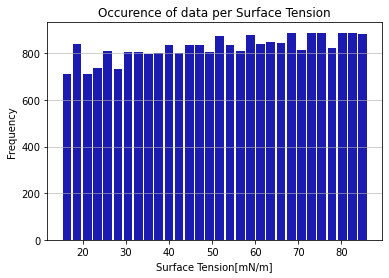

In [11]:

data_matrix_points = pd.read_csv("Data_folder/Data_Spline/Edge_points.csv", header= None)
data_matrix_spline = pd.read_csv("Data_folder/Data_Spline/Spline.csv", header= None)
#print(data_matrix_points)
print(data_matrix_spline)

# Make the droplet dataset class based on data_matrix
class Droplet_data_set(Dataset):
    def __init__(self,dataInput):
        x = dataInput.iloc[0:,3:].values
        y = dataInput.iloc[0:,0:2].values
        # x = np.random.normal(x,0.01)
        y0 = dataInput.iloc[:,0].values
        y1 = dataInput.iloc[:,1].values
        
        #Plot surface tension histogram
        n, bins, patches = plt.hist(x=y0, bins='auto', color='#0504aa',
                                    alpha=0.7, rwidth=0.85)
        plt.grid(axis='y', alpha=0.75)
        plt.xlabel('Surface Tension[mN/m]')
        # plt.xlabel('Volume[mm^3]')
        plt.ylabel('Frequency')
        plt.title('Occurence of data per Surface Tension')\

        #Plot volume histogram
        # n, bins, patches = plt.hist(x=y1, bins='auto', color='#0504aa',
        #                             alpha=0.7, rwidth=0.85)
        # plt.grid(axis='y', alpha=0.75)
        # plt.xlabel('Volume[mm^3]')
        # plt.ylabel('Frequency')
        # plt.title('Occurence of data per Volume')

        self.x_train = torch.tensor(x,dtype=torch.float32)
        self.y_train = torch.tensor(y,dtype=torch.float32)
        
    def __getitem__(self, idx):
        return self.x_train[idx],self.y_train[idx]
    
    def __len__(self):
         return len(self.y_train)
        
my_data_set_points = Droplet_data_set(data_matrix_points)
my_data_set_spline = Droplet_data_set(data_matrix_spline)

# Split the single dataset into 3 datasets for training, test and validation.
split_points = DataSplit(my_data_set_points, shuffle=True)
split_spline = DataSplit(my_data_set_spline, shuffle=True)

train_loader_points, val_loader_points, test_loader_points = split_points.get_split(batch_size=64, num_workers=0)
train_loader_spline, val_loader_spline, test_loader_spline = split_spline.get_split(batch_size=64, num_workers=0)


### Load data for PictureNet
Read image from files

In [12]:
train_img = []
data_matrix_points
data_image_points = data_matrix_points   # Large dataset
data_image_spline = data_matrix_spline

for img_name in data_image_points.iloc[0:,3:].index + 1:      # modify the number depends on size of dataset
    # defining the image path
    image_path = 'Data_folder/Data_Spline/' + str(img_name) + '.png'      # modify the path depends on which dataset
    # reading the image
    img = imread(image_path, as_gray=True)
    img = img[4:-4, 4:-4]  #crop 
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    train_img.append(img)

Plot a single image for viewing

Current image = 4442
Picture size = (82, 77)


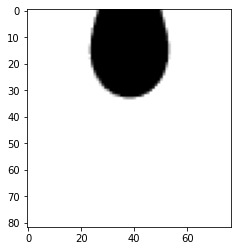

In [10]:
rand = random.randint(0, 53084)
print("Current image =", rand)
print("Picture size =", train_img[rand].shape)
plt.imshow(train_img[rand], cmap='gray')

<font color=red>
Rewrite the picture tensor generation into function.<br>
For training process to resuffle the batches!!!!!
</font>

In [16]:
# converting the list to numpy array
train_x_pic = np.array(train_img)
train_y_pic_points = data_image_points.iloc[0:,3:].values            # modify the number depends on size of dataset
train_y_pic_spline = data_image_spline.iloc[0:,3:].values            # modify the number depends on size of dataset

#Points data split
train_x_pic_points, rem_x_pic_points, train_y_pic_points, rem_y_pic_points = train_test_split(train_x_pic, train_y_pic_points, test_size = 0.2)    # default shuffle = True
val_x_pic_points, test_x_pic_points, val_y_pic_points, test_y_pic_points = train_test_split(rem_x_pic_points, rem_y_pic_points, test_size = 0.5)

#Spline data split
train_x_pic_spline, rem_x_pic_spline, train_y_pic_spline, rem_y_pic_spline = train_test_split(train_x_pic, train_y_pic_spline, test_size = 0.2)    # default shuffle = True
val_x_pic_spline, test_x_pic_spline, val_y_pic_spline, test_y_pic_spline = train_test_split(rem_x_pic_spline, rem_y_pic_spline, test_size = 0.5)

# converting the train images of points and targets into torch format
train_x_pic_points = train_x_pic_points.reshape(len(train_x_pic_points), 1, 82, 77)
train_x_pic_points  = torch.from_numpy(train_x_pic_points)
train_y_pic_points = torch.from_numpy(train_y_pic_points)

# converting the train images of spline and targets into torch format
train_x_pic_spline = train_x_pic_spline.reshape(len(train_x_pic_spline), 1, 82, 77)
train_x_pic_spline  = torch.from_numpy(train_x_pic_spline)
train_y_pic_spline = torch.from_numpy(train_y_pic_spline)


# converting the val images and target points into torch format
val_x_pic_points = val_x_pic_points.reshape(len(val_x_pic_points), 1, 82, 77)
val_x_pic_points  = torch.from_numpy(val_x_pic_points)
val_y_pic_points = torch.from_numpy(val_y_pic_points)
# print(val_x_pic_points.shape, val_y_pic_points.shape)

# converting the val images  and target spline into torch format
val_x_pic_spline = val_x_pic_spline.reshape(len(val_x_pic_spline), 1, 82, 77)
val_x_pic_spline  = torch.from_numpy(val_x_pic_spline)
val_y_pic_spline = torch.from_numpy(val_y_pic_spline)
# print(val_x_pic_spline.shape, val_y_pic_spline.shape)

# converting the test images and targets into torch format for points
test_x_pic_points = test_x_pic_points.reshape(len(test_x_pic_points), 1, 82, 77)
test_x_pic_points  = torch.from_numpy(test_x_pic_points)
test_y_pic_points = torch.from_numpy(test_y_pic_points)
# print(test_x_pic.shape, test_y_pic.shape)

# converting the test images and targets into torch format for spline
test_x_pic_spline = test_x_pic_spline.reshape(len(test_x_pic_spline), 1, 82, 77)
test_x_pic_spline  = torch.from_numpy(test_x_pic_spline)
test_y_pic_spline = torch.from_numpy(test_y_pic_spline)
# print(test_x_pic_spline.shape, test_y_pic_spline.shape)

# converting the dataset into mini-batch dataset (input 4D -> 5D and 2D -> 3D)
def batch_transform(dataset, batch_size=64):
    batch = []
    batch_num = math.ceil(len(dataset)/batch_size)
    for i in range(batch_num):
        if len(dataset) == 4:
            if i < batch_num-1:
                batch.append(dataset[i*batch_size:(i+1)*batch_size, :, :, :])
            else:
                batch.append(dataset[i*batch_size:, :, :, :])
        else:
            if i < batch_num-1:
                batch.append(dataset[i*batch_size:(i+1)*batch_size, :])
            else:
                batch.append(dataset[i*batch_size:, :])
    return batch

train_x_pic_points = batch_transform(train_x_pic_points)
train_y_pic_points = batch_transform(train_y_pic_points)
val_x_pic_points = batch_transform(val_x_pic_points)
val_y_pic_points = batch_transform(val_y_pic_points)
test_x_pic_points = batch_transform(test_x_pic_points)
test_y_pic_points = batch_transform(test_y_pic_points)
print(len(train_x_pic_points), len(train_y_pic_points), len(val_x_pic_points), len(val_y_pic_points), len(test_x_pic_points), len(test_y_pic_points))

train_x_pic_spline = batch_transform(train_x_pic_spline)
train_y_pic_spline = batch_transform(train_y_pic_spline)
val_x_pic_spline = batch_transform(val_x_pic_spline)
val_y_pic_spline = batch_transform(val_y_pic_spline)
test_x_pic_spline = batch_transform(test_x_pic_spline)
test_y_pic_spline = batch_transform(test_y_pic_spline)
print(len(train_x_pic_spline), len(train_y_pic_spline), len(val_x_pic_spline), len(val_y_pic_spline), len(test_x_pic_spline), len(test_y_pic_spline))



310 310 39 39 39 39
310 310 39 39 39 39


### Deside to apply host or device


In [6]:
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
#device = torch.device('cpu')
print(device)

cuda


## Define the functions

In [17]:
def loss_cal_phiysics(loss_list, model, loader):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        loss_epoch = 0
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)
            loss_epoch += loss
        loss_list.append(loss_epoch.cpu().data.numpy()/t)

def loss_cal_picture(loss_list, model, x_dataset, y_dataset):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        loss_epoch = 0
        for t in range(len(x_dataset)):
            x = x_dataset[t]
            y = y_dataset[t]
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)
            loss_epoch += loss
        loss_list.append(loss_epoch.cpu().data.numpy()/t)

def prediction(model, x):   # only a batch
    model = model.to(device=device)
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        x = x.to(device=device, dtype=torch.float32)
        score = torch.Tensor.cpu(model(x))
    return score

def model_selection(model, path, loss, epoch_current, epoch_ref, loss_ref):
    loss_best = loss_ref
    epoch_best = epoch_ref
    if epoch_current == 0:
            loss_current = loss[epoch_current]
            loss_best = loss[epoch_current]
            torch.save(model, path)
    else:
        loss_current = loss[epoch_current]
        if loss_current <= (loss_best * 1.1):   # 10% margin to get better fitting but a bit more loss
            loss_best = loss_current
            epoch_best = epoch_current
            torch.save(model, path)
    return loss_best, epoch_best

def train_physics(model, optimizer, epochs=1, model_input=0):
    loss_train = []
    loss_val = []
    loss_best = 0
    epoch_best = 0
    if model_input == 0:
        train_loader = train_loader_points
        val_loader = val_loader_points
        PATH_CAL = os.path.join(os.getcwd(), "model_cal_points.pt")
    elif model_input == 1:
        train_loader = train_loader_spline
        val_loader = val_loader_spline
        PATH_CAL = os.path.join(os.getcwd(), "model_cal_spline.pt")
    else:
        ValueError("Incorrect input. 0 for edge point model, 1 for spline model")


    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for _, (x, y) in enumerate(train_loader):
            x = x.reshape(len(x), 1, 1, -1)     # reshape to 4D data for formal input of model
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_cal_phiysics(loss_train, model, train_loader)
        loss_cal_phiysics(loss_val, model, val_loader)
        print('epoch %d: train_loss = %.4f, val_loss = %.4f' % (e+1, loss_train[e], loss_val[e]))

        # selecting the best model to save
        loss_best, epoch_best = model_selection(model, PATH_CAL, loss_train, e, epoch_best, loss_best)
    
    print("The model is saved at epoch =", epoch_best+1, "and the loss =", loss_best.item())
    
    x = range(1, epochs+1)

    plt.semilogy(x, loss_train, 'b-', label="training loss")
    plt.semilogy(x, loss_val, 'r--', label="validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("Train/Validation Loss")
    plt.legend()
    plt.show()

def train_picture(model, optimizer, epochs=1, model_input=0):
    loss_train = []
    loss_val = []
    loss_best = 0
    epoch_best = 0
    if model_input == 0:
        train_x_pic = train_x_pic_points
        train_y_pic = train_y_pic_points
        val_x_pic = val_x_pic_points
        val_y_pic = val_y_pic_points
        PATH_PIC = os.path.join(os.getcwd(), "model_pic_points.pt")
    elif model_input == 1:
        train_x_pic = train_x_pic_spline
        train_y_pic = train_y_pic_spline
        val_x_pic = val_x_pic_spline
        val_y_pic = val_y_pic_spline
        PATH_PIC = os.path.join(os.getcwd(), "model_pic_spline.pt")
    else:
        ValueError("Incorrect input. 0 for edge point model, 1 for spline model")

    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t in range(len(train_x_pic)):
            model.train()  # put model to training mode
            x = train_x_pic[t]
            y = train_y_pic[t]
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)

            scores = model(x)
            loss = F.mse_loss(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_cal_picture(loss_train, model, train_x_pic, train_y_pic)
        loss_cal_picture(loss_val, model, val_x_pic, val_y_pic)
        print('epoch %d: train_loss = %.4f, val_loss = %.4f' % (e+1, loss_train[e], loss_val[e]))
        
        # selecting the best model to save
        loss_best, epoch_best = model_selection(model, PATH_PIC, loss_train, e, epoch_best, loss_best)
    
    print("The model is saved at epoch =", epoch_best+1, "and the loss =", loss_best.item())

    x = range(1, epochs+1)

    plt.semilogy(x, loss_train, 'b-', label="training loss")
    plt.semilogy(x, loss_val, 'r--', label="validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("Train/Validation Loss")
    plt.legend()
    plt.show()


## Train PhysicsNet Edge Points

epoch 1: train_loss = 1235.9663, val_loss = 1287.0857
epoch 2: train_loss = 703.7902, val_loss = 732.2401
epoch 3: train_loss = 293.0129, val_loss = 305.3996
epoch 4: train_loss = 124.6735, val_loss = 132.3110
epoch 5: train_loss = 25.2782, val_loss = 26.9356
The model is saved at epoch = 5 and the loss = 25.278202633205936


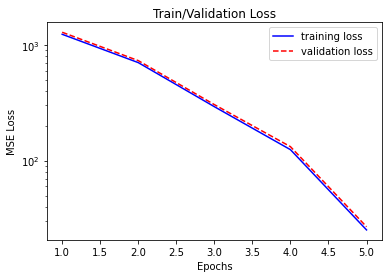

In [8]:
in_channel = 160
node_1 = 1024
node_2 = 1024
node_3 = 512
node_4 = 256
node_5 = 64
node_6 = 16
out_channel = 2

learning_rate = 1e-3

model_physics = PhysicsNet(in_channel, node_1, node_2, node_3, node_4, node_5, node_6, out_channel)
optimizer = optim.Adam(model_physics.parameters(), lr=learning_rate)
epoch = 5
# 0 indicates edge points 1 indicates spline
train_physics(model_physics, optimizer, epoch, 0)

# Train PhysicsNet spline

epoch 1: train_loss = 1412.6369, val_loss = 1455.6565
epoch 2: train_loss = 723.9688, val_loss = 741.2359
epoch 3: train_loss = 355.2187, val_loss = 361.7372
epoch 4: train_loss = 110.9597, val_loss = 112.5811
epoch 5: train_loss = 30.4710, val_loss = 31.0739
The model is saved at epoch = 5 and the loss = 30.470984150179856


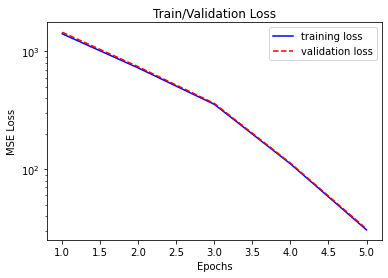

In [9]:

in_channel = 22

model_physics = PhysicsNet(in_channel, node_1, node_2, node_3, node_4, node_5, node_6, out_channel)
optimizer = optim.Adam(model_physics.parameters(), lr=learning_rate)

# 0 indicates edge points 1 indicates spline
train_physics(model_physics, optimizer, epoch, 1)


### Retrain with SGD
<font color=red>
To be verify the effect!!
</font>

epoch 1: train_loss = 1.2516, val_loss = 1.1676
epoch 2: train_loss = 2.0603, val_loss = 1.9840
epoch 3: train_loss = 1.7456, val_loss = 1.6805
epoch 4: train_loss = 1.3275, val_loss = 1.2742
epoch 5: train_loss = 1.4718, val_loss = 1.3973
epoch 6: train_loss = 1.8269, val_loss = 1.7414
epoch 7: train_loss = 2.1763, val_loss = 2.1009
epoch 8: train_loss = 2.0320, val_loss = 1.9694
epoch 9: train_loss = 0.9214, val_loss = 0.8487
epoch 10: train_loss = 1.0861, val_loss = 1.0143
epoch 11: train_loss = 1.5902, val_loss = 1.5210
epoch 12: train_loss = 1.3247, val_loss = 1.2586
epoch 13: train_loss = 1.4773, val_loss = 1.4264
epoch 14: train_loss = 1.8512, val_loss = 1.7720
epoch 15: train_loss = 2.0613, val_loss = 1.9736
epoch 16: train_loss = 1.5136, val_loss = 1.4429
epoch 17: train_loss = 0.7093, val_loss = 0.6357
epoch 18: train_loss = 1.6743, val_loss = 1.5795
epoch 19: train_loss = 1.3101, val_loss = 1.2444
epoch 20: train_loss = 1.4122, val_loss = 1.3634
epoch 21: train_loss = 1.7474

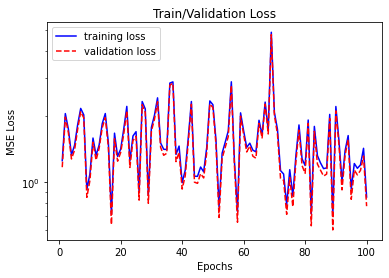

In [263]:
# PATH_CAL = os.path.join(os.getcwd(), "model_cal.pt")
# model_physics_trained = torch.load(PATH_CAL)

# learning_rate = 1e-4

# optimizer = optim.SGD(model_physics_trained.parameters(), lr=learning_rate)
# epoch = 100

# train_physics(model_physics_trained, optimizer, epoch)

### Visualization of outcomes

In [10]:
PATH_CAL_POINTS = os.path.join(os.getcwd(), "model_cal_points.pt")
PATH_CAL_SPLINE = os.path.join(os.getcwd(), "model_cal_spline.pt")

model_physics_trained_points = torch.load(PATH_CAL_POINTS)
model_physics_trained_spline = torch.load(PATH_CAL_SPLINE)

examples = enumerate(test_loader_points)
_, (x_test_points, y_test_points) = next(examples)


score_example_points = prediction(model_physics_trained_points, x_test_points)

#Not working
#score_example_spline = prediction(model_physics_trained_spline, x_test_points)

# y = data_matrix.iloc[0:,0:2].values
#Revert normalized values back to real values
# Print only 8 data samples for comparison
print("Ground Truths =", y_test_points[:8])
print("Prediction Points    =", score_example_points[:8].reshape(8, 2))
#print("Prediction Spline    =", score_example_spline[:8].reshape(8, 2))

Ground Truths = tensor([[33.0000, 11.7136],
        [52.3000, 21.3765],
        [33.6000, 10.9769],
        [55.0000, 17.7280],
        [46.3000, 16.6372],
        [52.4000, 13.8598],
        [50.6000, 19.9065],
        [65.3000, 23.3074]])
Prediction Points    = tensor([[28.5014, 12.0431],
        [49.7774, 21.0013],
        [28.6100, 12.0789],
        [49.3420, 19.7906],
        [41.4418, 16.2146],
        [43.2902, 16.7355],
        [47.0750, 19.3389],
        [59.1301, 24.3378]])


## Train PictureNet edge points

<font color=red> 
The more we train (higher epoch), the more model learns to make points connect smoother. However, the loss becomes larger.<br>
Apply early stopping and save the best model? 
</font>

epoch 1: train_loss = 0.5629, val_loss = 0.5780
epoch 2: train_loss = 1.0127, val_loss = 1.0494
epoch 3: train_loss = 0.5458, val_loss = 0.5669
epoch 4: train_loss = 0.0144, val_loss = 0.0151
epoch 5: train_loss = 0.2435, val_loss = 0.2533
The model is saved at epoch = 4 and the loss = 0.014411466407158614


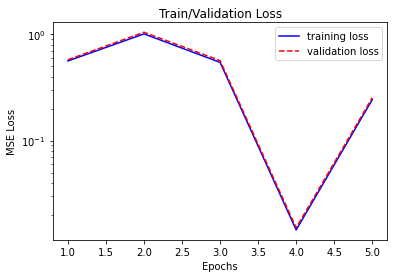

In [18]:
in_channel = 1
channel_1 = 16
channel_2 = 32
channel_3 = 64
node_1 = 1024
node_2 = 1024
out_channel = 160

learning_rate = 1e-3

model_picture = PictureNet(in_channel, channel_1, channel_2, channel_3, node_1, node_2, out_channel)
optimizer = optim.Adam(model_picture.parameters(), lr=learning_rate)
epoch = 5

train_picture(model_picture, optimizer, epoch,0)


# Train PictureNet for spline


epoch 1: train_loss = 0.0065, val_loss = 0.0066
epoch 2: train_loss = 0.0053, val_loss = 0.0054
epoch 3: train_loss = 0.0027, val_loss = 0.0028
epoch 4: train_loss = 0.0008, val_loss = 0.0008
epoch 5: train_loss = 0.0016, val_loss = 0.0017
The model is saved at epoch = 4 and the loss = 0.0007912110067108302


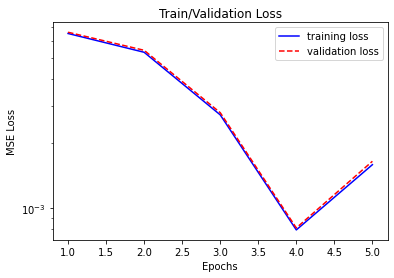

In [19]:
out_channel = 22

learning_rate = 1e-3

model_picture = PictureNet(in_channel, channel_1, channel_2, channel_3, node_1, node_2, out_channel)
optimizer = optim.Adam(model_picture.parameters(), lr=learning_rate)

train_picture(model_picture, optimizer, epoch,1)


### Visualization of outcomes

In [22]:
# testing cell for better viewing the length
train_x_pic_points, train_y_pic_points

print(len(train_x_pic_points))
print(train_x_pic_points[0].shape)
print(train_y_pic_points[0].shape)

310
torch.Size([64, 1, 82, 77])
torch.Size([64, 160])


In [24]:
PATH_PIC = os.path.join(os.getcwd(), "model_pic_points.pt")
model_picture_trained = torch.load(PATH_PIC)

rand1 = random.randint(0, len(test_x_pic_points)-1)
rand2 = random.randint(0, 63)

print("current batch =", rand1)
print("current testing image =", rand2)

score_pic = prediction(model_picture_trained, test_x_pic_points[rand1][rand2].reshape(1, 1, 82, 77))
for num in range(len(test_y_pic_points[rand1][rand2])):
    print(num+1, ": Ground Truths =", test_y_pic_points[rand1][rand2][num].item(), ", Prediction =", score_pic[0, num].item())


current batch = 27
current testing image = 19
1 : Ground Truths = 4.7191250138593697e-26 , Prediction = 0.000960836187005043
2 : Ground Truths = 0.0610082206539101 , Prediction = 0.028527306392788887
3 : Ground Truths = 0.121925899087155 , Prediction = 0.11822250485420227
4 : Ground Truths = 0.182668545540749 , Prediction = 0.188765749335289
5 : Ground Truths = 0.243143099171707 , Prediction = 0.24506305158138275
6 : Ground Truths = 0.303251127430726 , Prediction = 0.262248694896698
7 : Ground Truths = 0.362938824901877 , Prediction = 0.3187839388847351
8 : Ground Truths = 0.422085771387957 , Prediction = 0.37602415680885315
9 : Ground Truths = 0.480615676587018 , Prediction = 0.46110162138938904
10 : Ground Truths = 0.538473627559553 , Prediction = 0.4633999466896057
11 : Ground Truths = 0.595530340040294 , Prediction = 0.5488470792770386
12 : Ground Truths = 0.651756729975795 , Prediction = 0.6472170948982239
13 : Ground Truths = 0.707054753155366 , Prediction = 0.6670929193496704
14

### Plot the ground truth and prediction to make a comparison

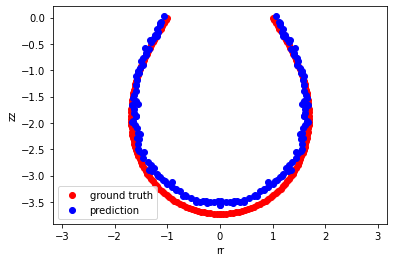

In [25]:
# scattering points for ground truth
x_gt_pos = test_y_pic_points[rand1][rand2][0:80]
y_gt_pos = test_y_pic_points[rand1][rand2][80:160]
x_gt_neg = -torch.flip(x_gt_pos, [0])
y_gt_neg = torch.flip(y_gt_pos, [0])
x_gt = torch.cat((x_gt_neg, x_gt_pos))
y_gt = torch.cat((y_gt_neg, y_gt_pos))

# scattering points for prediction
x_pred_pos = score_pic[0, 0:80]
y_pred_pos = score_pic[0, 80:160]
x_pred_neg = -torch.flip(x_pred_pos, [0])
y_pred_neg = torch.flip(y_pred_pos, [0])
x_pred = torch.cat((x_pred_neg, x_pred_pos))
y_pred = torch.cat((y_pred_neg, y_pred_pos))

plt.scatter(x_gt, y_gt, c="red", label="ground truth")
plt.scatter(x_pred, y_pred, c="blue", label="prediction")
plt.xlabel("rr")
plt.ylabel("zz")
plt.legend()
plt.axis('equal')
plt.show()